In [1]:
import heapq
import matplotlib.pyplot as plt
import torch
import json
import random
from torch.utils.data import Dataset
from value_network import ValueNetwork
from value_network import CubeDataset
from environment import RubiksCubeEnv
import time
from tqdm import tqdm

Using device: cuda


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def one_hot_encode(cube_state):
  # Convert the cube state to the input format expected by the model
  state_oh = []

  # Iterate over each face's colors
  for face in cube_state:
    for pair in face:
      for color in pair:
        # Create a one-hot encoded vector for this color
        color_oh = [0] * 6
        color_oh[color] = 1
        state_oh.extend(color_oh)

  return torch.tensor(state_oh, dtype=torch.float)


def one_hot_decode(encoded_state):
  # Convert the one-hot encoded tensor back to the original cube state
  decoded_state = []
  for i in range(0, len(encoded_state), 6):
    color_vector = encoded_state[i:i + 6]
    color = torch.argmax(color_vector).item()
    decoded_state.append(color)

  # Group the colors back into the original cube structure
  original_state = []
  for i in range(0, len(decoded_state), 4):
    face_colors = decoded_state[i:i + 4]
    original_state.append([face_colors[j:j + 2] for j in range(0, 4, 2)])

  return original_state


def heuristic(cube_state, model):
  """ Estimate the cost to solve the cube from the given state using the given model """
  # state_oh = one_hot_encode(cube_state)
  # Add batch dimension and move to device
  state_oh = cube_state.unsqueeze(0).to(device)

  with torch.no_grad():
    cost_estimate = model(state_oh).item()  # Get the heuristic value
  return cost_estimate

In [3]:
def reconstruct_path(came_from, current_state):
  """ Reconstruct the path from the start state to the current state using the came_from dictionary"""
  total_path = [current_state]
  while current_state in came_from:
    current_state, action = came_from[current_state]
    # Prepend action because we are tracing back the path
    total_path.insert(0, action)
  return total_path


def generate_all_possible_actions(cube_size):
  """ Generate all possible actions for the given cube size """
  actions = []
  for side in [0, 1]:
    for layer in range(cube_size):
      for angle in [0, 1]:
        action = (side, layer, angle)
        actions.append(action)

  return actions


def reverse_move(action):
  """ Reverse the given action """
  return (action[0], action[1], 1 - action[2])

In [5]:
def astar_search(model, env, initial_scramble=2, max_explored_states=200, lambda_weight=1):
  """ Perform an A* search to solve the cube from the given state using the given model
  lambda_weight is a parameter that can be used to adjust the weight of the heuristic in the f score
  to control the tradeoff between the heuristic and the cost to reach the current state.
  """
  env.reset(0)
  initial_actions = []

  # Scramble the cube with random actions
  for _ in range(initial_scramble):
    action = random.choice(generate_all_possible_actions(env.cube_size))
    env.step(action)
    initial_actions.append(action)

  initial_state = env.get_state()
  initial_state_encoded = one_hot_encode(initial_state)
  initial_path = []

  # Initialize the open and closed sets
  open_set = set([tuple(initial_state_encoded.tolist())])
  closed_set = set()

  # Initialize the g and f scores for each state
  g_score = {tuple(initial_state_encoded.tolist()): 0}
  f_score = {tuple(initial_state_encoded.tolist()): heuristic(
    initial_state_encoded, model) * lambda_weight}
  came_from = {tuple(initial_state_encoded.tolist()): initial_path}

  explored_states_count = 0

  while open_set and explored_states_count < max_explored_states:
    explored_states_count += 1
    current_encoded = min(open_set, key=lambda o: f_score[o])
    current_path = came_from[current_encoded]

    # Reset to the initial state and reapply the actions to get to the current state
    env.reset(0)
    for action in initial_actions + current_path:
      env.step(action)

    # Check if the current state is the goal state
    if env.is_solved(env.get_state()):
      return current_path

    open_set.remove(current_encoded)
    closed_set.add(current_encoded)

    # Generate all possible actions and apply them to the current state
    for action in generate_all_possible_actions(env.cube_size):
      env.step(action)
      new_state = env.get_state()
      new_state_encoded = one_hot_encode(new_state)
      new_path = current_path + [action]

      if tuple(new_state_encoded.tolist()) in closed_set:
        env.step(reverse_move(action))  # Reverse the action to undo it
        continue

      tentative_g_score = g_score[current_encoded] + 1
      tentative_f_score = tentative_g_score + \
          heuristic(new_state_encoded, model) * lambda_weight

      # If the new state is not in the open set or the new path has a lower f score, update the open set and scores
      if tuple(new_state_encoded.tolist()) not in open_set or tentative_f_score < f_score.get(tuple(new_state_encoded.tolist()), float('inf')):
        open_set.add(tuple(new_state_encoded.tolist()))
        came_from[tuple(new_state_encoded.tolist())] = new_path
        g_score[tuple(new_state_encoded.tolist())] = tentative_g_score
        f_score[tuple(new_state_encoded.tolist())] = tentative_f_score

      env.step(reverse_move(action))  # Reverse the action to undo it

  print("Reached maximum number of explored states without finding a solution.")
  return None

In [20]:
def test_astar(model_paths, cube_sizes, costs_to_go, env_setup):
  """ Test the A* search algorithm with the given model paths, cube sizes, and costs_to_go"""
  solve_rates = {size: [] for size in cube_sizes}
  move_counts = {size: [] for size in cube_sizes}

  for size in cube_sizes:
    network_path = model_paths[size]
    if size == 2:
      model = ValueNetwork(144).to(device)
      costs_to_go = range(0, 12)
    elif size == 3:
      model = ValueNetwork(324).to(device)
      costs_to_go = range(0, 15)
    elif size == 4:
      model = ValueNetwork(576).to(device)
      costs_to_go = range(0, 15)
    model.load_state_dict(torch.load(network_path, map_location=device))
    model.eval()
    env = RubiksCubeEnv(**env_setup, cube_size=size)

    for cost_to_go in costs_to_go:
      print(f"Testing {size}x{size}x{size} cube with cost_to_go {cost_to_go}")
      solve_count = 0
      total_moves = 0
      attempts = 10

      for _ in tqdm(range(attempts)):
        actions = astar_search(model, env, cost_to_go)

        if actions is not None:
          solve_count += 1
          total_moves += len(actions)

      solve_rate = solve_count / attempts
      avg_moves = total_moves / solve_count if solve_count > 0 else 0

      solve_rates[size].append(solve_rate)
      move_counts[size].append(avg_moves)

  return solve_rates, move_counts

In [29]:
def plot_results(solve_rates, move_counts, costs_to_go):
  """ Plot the solve rates and move counts for the given cost-to-go values"""
  plt.figure(figsize=(14, 6))

  colors = {'2': '#425066', '3': '#12b5cb', '4': '#e52592'}

  max_length = max(len(costs_to_go), max(len(rates) for rates in solve_rates.values(
  )), max(len(counts) for counts in move_counts.values()))

  # Adjust the lengths of the lists to match the maximum possible length - there was a bug when the lengths were different
  if len(costs_to_go) < max_length:
    # print(f"Warning: 'costs_to_go' length is less than some of the 'rates' or 'counts'. Adjusting 'x_values' accordingly.")
    costs_to_go = costs_to_go + [None] * (max_length - len(costs_to_go))

  for size, rates in solve_rates.items():
    x_values = costs_to_go[:len(rates)]
    plt.plot(x_values, rates, '-o',
             label=f'{size}x{size}x{size}', color=colors[str(size)])

  plt.title('Wskaźnik rozwiązywalności w zależności od cost-to-go')
  plt.xlabel('Cost-to-go')
  # Adjust xticks to match the maximum possible length
  plt.xticks(costs_to_go[:max_length])
  plt.ylabel('Solve Rate')
  plt.legend()
  plt.grid(True)
  plt.savefig('solve_rate_vs_cost_to_go.png')
  plt.show()

  plt.figure(figsize=(14, 6))

  for size, counts in move_counts.items():
    x_values = costs_to_go[:len(counts)]
    plt.plot(x_values, counts, '-o',
             label=f'{size}x{size}x{size}', color=colors[str(size)])

  plt.title('Średnia ilość ruchów w zależności od cost-to-go')
  plt.xlabel('Cost-to-go')
  # Adjust xticks to match the maximum possible length
  plt.xticks(costs_to_go[:max_length])
  plt.ylabel('Średnia ilość ruchów')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.tight_layout()
  plt.savefig('average_move_count_vs_cost_to_go.png')

In [9]:
""" Test for solve rate and average moves """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = {
    2: './networks/best_value_network_2x2x2.pth',
    3: './networks/best_value_network_3x3x3.pth',
    4: './networks/best_value_network_4x4x4.pth'
}
cube_sizes = [2, 3, 4]
cost_to_gos = range(0, 14)
env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'animation_enabled': False
}

solve_rates_2x2x2, move_counts_2x2x2 = test_astar(
  model_paths, cube_sizes, cost_to_gos, env_setup)

{'status': 'initialized'}
Testing 2x2x2 cube with difficulty 0


100%|██████████| 10/10 [00:00<00:00, 10.21it/s]


Testing 2x2x2 cube with difficulty 1


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Testing 2x2x2 cube with difficulty 2


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Testing 2x2x2 cube with difficulty 3


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Testing 2x2x2 cube with difficulty 4


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Testing 2x2x2 cube with difficulty 5


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Testing 2x2x2 cube with difficulty 6


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Testing 2x2x2 cube with difficulty 7


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]


Testing 2x2x2 cube with difficulty 8


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


Testing 2x2x2 cube with difficulty 9


100%|██████████| 10/10 [01:19<00:00,  7.99s/it]


Testing 2x2x2 cube with difficulty 10


100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


Testing 2x2x2 cube with difficulty 11


100%|██████████| 10/10 [02:10<00:00, 13.05s/it]


{'status': 'initialized'}
Testing 3x3x3 cube with difficulty 0


100%|██████████| 10/10 [00:01<00:00,  9.65it/s]


Testing 3x3x3 cube with difficulty 1


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Testing 3x3x3 cube with difficulty 2


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


Testing 3x3x3 cube with difficulty 3


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Testing 3x3x3 cube with difficulty 4


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


Testing 3x3x3 cube with difficulty 5


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


Testing 3x3x3 cube with difficulty 6


100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Testing 3x3x3 cube with difficulty 7


100%|██████████| 10/10 [01:10<00:00,  7.03s/it]


Testing 3x3x3 cube with difficulty 8


 80%|████████  | 8/10 [05:27<02:05, 62.51s/it] 

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [08:27<00:00, 50.73s/it]


Reached maximum number of explored states without finding a solution.
Testing 3x3x3 cube with difficulty 9


100%|██████████| 10/10 [01:14<00:00,  7.48s/it]


Testing 3x3x3 cube with difficulty 10


 70%|███████   | 7/10 [04:09<03:19, 66.56s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [04:48<00:00, 28.84s/it]


Testing 3x3x3 cube with difficulty 11


 50%|█████     | 5/10 [06:58<07:58, 95.69s/it] 

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [08:38<00:00, 51.82s/it]


Testing 3x3x3 cube with difficulty 12


 60%|██████    | 6/10 [04:36<04:49, 72.31s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [07:43<05:28, 109.65s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [08:29<00:00, 50.98s/it]


Testing 3x3x3 cube with difficulty 13


 10%|█         | 1/10 [03:12<28:53, 192.56s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [06:39<15:48, 135.57s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [09:50<15:43, 157.25s/it]

Reached maximum number of explored states without finding a solution.


 80%|████████  | 8/10 [14:10<03:19, 99.77s/it] 

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [17:29<00:00, 104.96s/it]


Reached maximum number of explored states without finding a solution.
Testing 3x3x3 cube with difficulty 14


 20%|██        | 2/10 [03:29<16:09, 121.21s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [06:44<18:03, 154.78s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [09:59<17:04, 170.77s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [13:57<09:53, 148.49s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [15:48<00:00, 94.84s/it]


{'status': 'initialized'}
Testing 4x4x4 cube with difficulty 0


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Testing 4x4x4 cube with difficulty 1


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Testing 4x4x4 cube with difficulty 2


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Testing 4x4x4 cube with difficulty 3


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


Testing 4x4x4 cube with difficulty 4


100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


Testing 4x4x4 cube with difficulty 5


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


Testing 4x4x4 cube with difficulty 6


100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


Testing 4x4x4 cube with difficulty 7


 70%|███████   | 7/10 [04:46<04:08, 82.84s/it]

Reached maximum number of explored states without finding a solution.


 80%|████████  | 8/10 [08:38<04:20, 130.16s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [08:54<00:00, 53.48s/it]


Testing 4x4x4 cube with difficulty 8


 30%|███       | 3/10 [04:31<13:36, 116.63s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [08:27<10:49, 129.84s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [13:00<00:00, 78.02s/it]


Reached maximum number of explored states without finding a solution.
Testing 4x4x4 cube with difficulty 9


100%|██████████| 10/10 [04:08<00:00, 24.81s/it]


Testing 4x4x4 cube with difficulty 10


 30%|███       | 3/10 [04:20<13:24, 114.95s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [05:12<07:48, 78.01s/it] 


ConnectionResetError: [Errno 104] Connection reset by peer

In [12]:
cube_sizes = [2]
cost_to_gos = range(0, 12)
env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'animation_enabled': False
}
solve_rates_2x2x2, move_counts_2x2x2 = test_astar(
  model_paths, cube_sizes, cost_to_gos, env_setup)

{'status': 'initialized'}
Testing 2x2x2 cube with difficulty 0


100%|██████████| 10/10 [00:00<00:00, 11.63it/s]


Testing 2x2x2 cube with difficulty 1


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Testing 2x2x2 cube with difficulty 2


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Testing 2x2x2 cube with difficulty 3


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Testing 2x2x2 cube with difficulty 4


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Testing 2x2x2 cube with difficulty 5


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Testing 2x2x2 cube with difficulty 6


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]


Testing 2x2x2 cube with difficulty 7


100%|██████████| 10/10 [00:40<00:00,  4.01s/it]


Testing 2x2x2 cube with difficulty 8


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Testing 2x2x2 cube with difficulty 9


100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


Testing 2x2x2 cube with difficulty 10


100%|██████████| 10/10 [00:49<00:00,  4.90s/it]


Testing 2x2x2 cube with difficulty 11


100%|██████████| 10/10 [02:09<00:00, 12.98s/it]


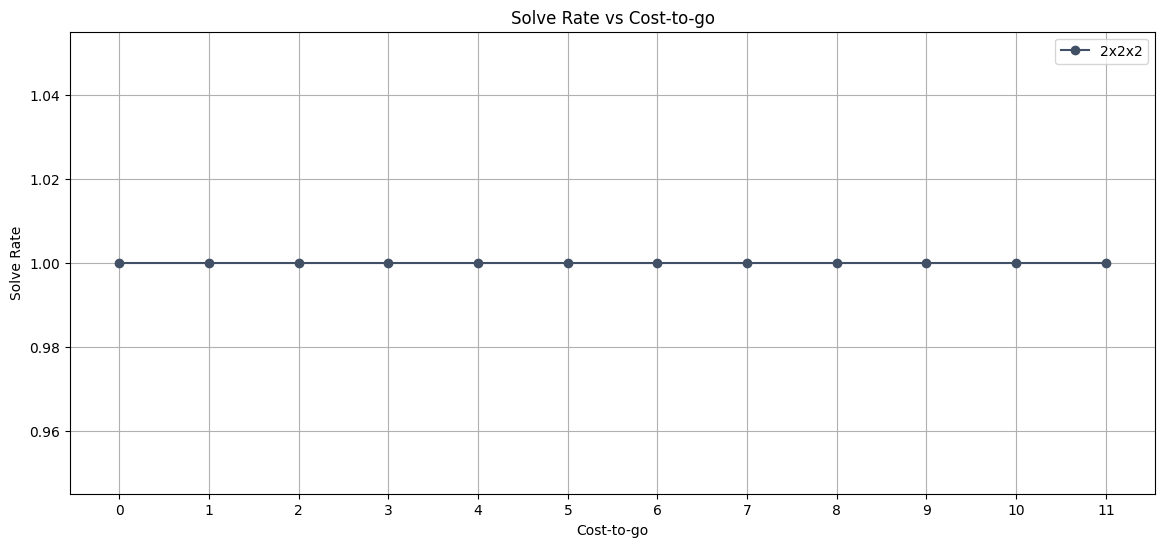

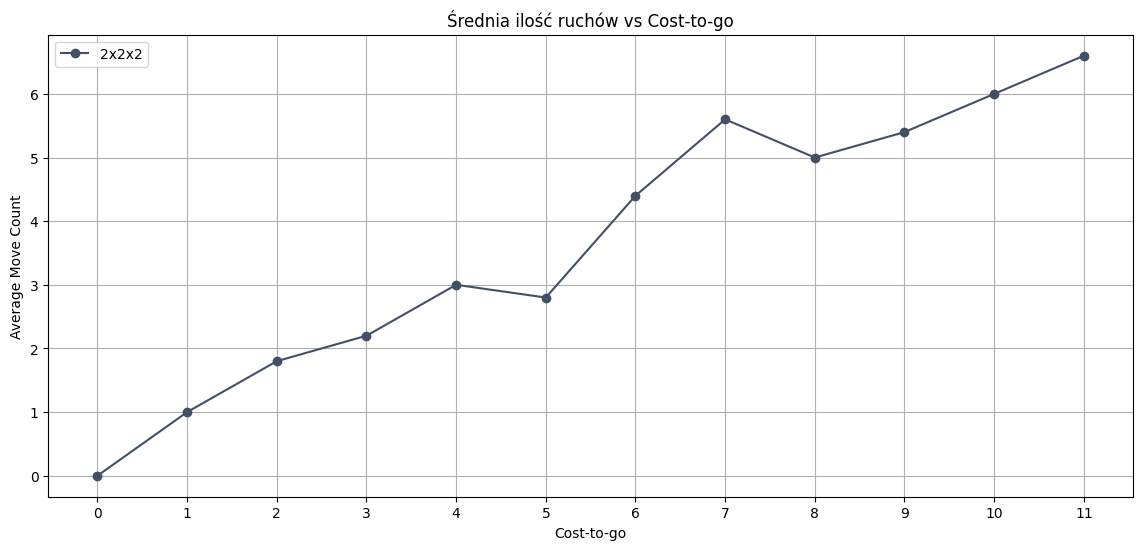

<Figure size 640x480 with 0 Axes>

In [13]:
plot_results(solve_rates_2x2x2, move_counts_2x2x2, cost_to_gos)

{'status': 'initialized'}
Testing 3x3x3 cube with difficulty 0


100%|██████████| 10/10 [00:01<00:00,  9.50it/s]


Testing 3x3x3 cube with difficulty 1


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Testing 3x3x3 cube with difficulty 2


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


Testing 3x3x3 cube with difficulty 3


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


Testing 3x3x3 cube with difficulty 4


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


Testing 3x3x3 cube with difficulty 5


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


Testing 3x3x3 cube with difficulty 6


100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Testing 3x3x3 cube with difficulty 7


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Testing 3x3x3 cube with difficulty 8


 90%|█████████ | 9/10 [03:48<01:00, 60.56s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [03:54<00:00, 23.49s/it]


Testing 3x3x3 cube with difficulty 9


 40%|████      | 4/10 [03:48<08:15, 82.58s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [06:48<09:47, 117.43s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [09:48<09:15, 138.88s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [10:30<00:00, 63.01s/it]


Testing 3x3x3 cube with difficulty 10


 20%|██        | 2/10 [03:11<14:53, 111.68s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [07:33<00:00, 45.39s/it]


Testing 3x3x3 cube with difficulty 11


 70%|███████   | 7/10 [04:36<03:34, 71.59s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [08:21<00:00, 50.11s/it]


Reached maximum number of explored states without finding a solution.
Testing 3x3x3 cube with difficulty 12


 10%|█         | 1/10 [03:09<28:25, 189.48s/it]

Reached maximum number of explored states without finding a solution.


 20%|██        | 2/10 [06:20<25:24, 190.55s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [09:27<22:00, 188.58s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [12:50<00:00, 77.09s/it]


Testing 3x3x3 cube with difficulty 13


 10%|█         | 1/10 [03:13<28:58, 193.12s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [09:41<09:59, 119.99s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [13:00<05:53, 117.77s/it]

Reached maximum number of explored states without finding a solution.


 80%|████████  | 8/10 [16:11<04:41, 140.95s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [16:34<00:00, 99.48s/it]


Testing 3x3x3 cube with difficulty 14


 10%|█         | 1/10 [03:17<29:37, 197.45s/it]

Reached maximum number of explored states without finding a solution.


 20%|██        | 2/10 [06:32<26:08, 196.12s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [09:48<22:51, 195.93s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [13:01<19:29, 194.98s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [16:40<10:17, 154.36s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [19:55<08:23, 167.73s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [23:59<00:00, 143.96s/it]

Reached maximum number of explored states without finding a solution.


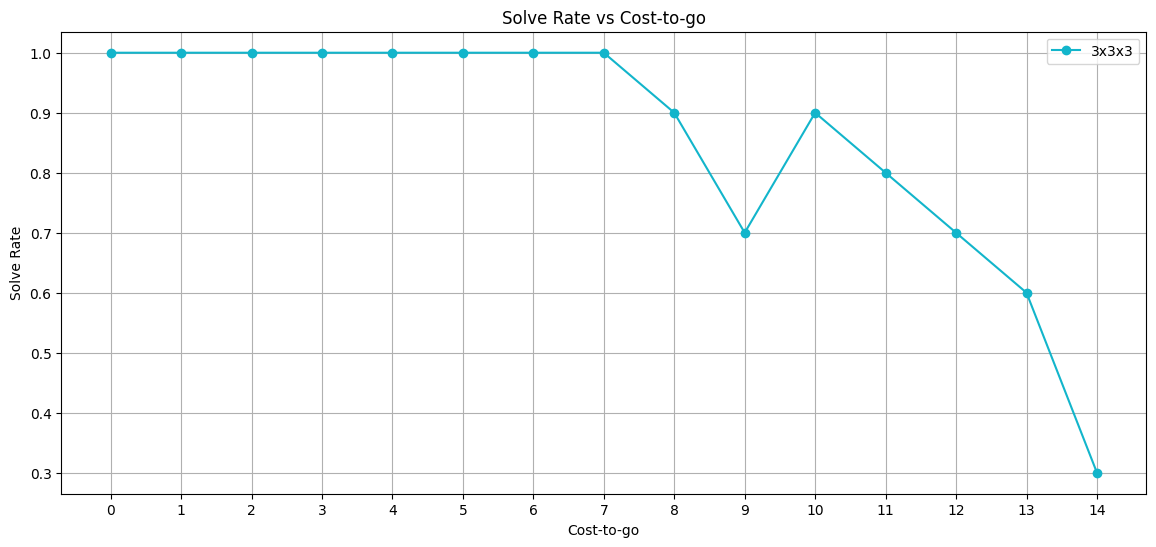

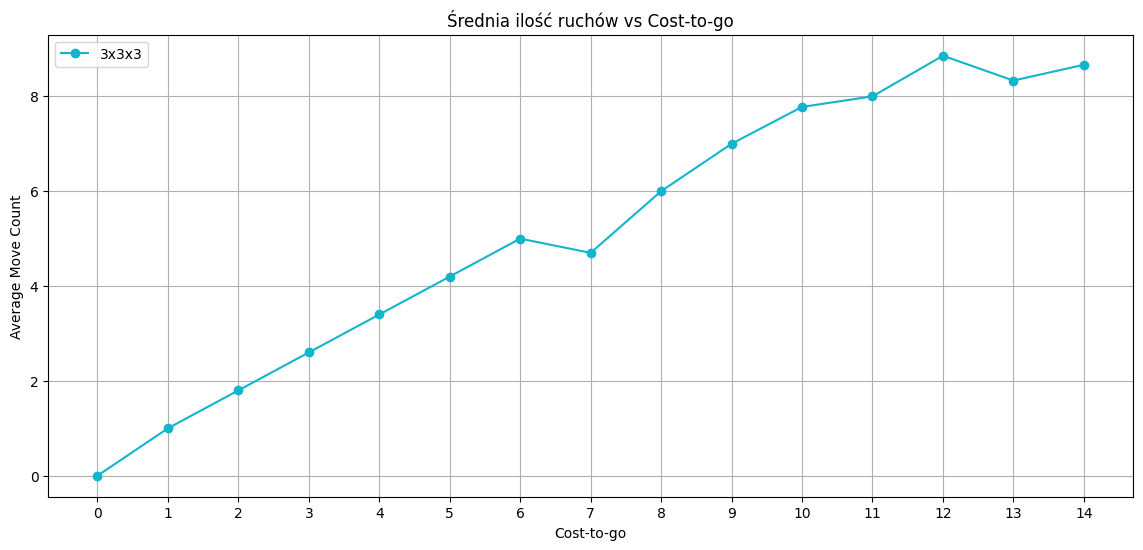

<Figure size 640x480 with 0 Axes>

In [22]:
cube_sizes = [3]
cost_to_gos = range(0, 15)
env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'animation_enabled': False
}
solve_rates_3x3x3, move_counts_3x3x3 = test_astar(
  model_paths, cube_sizes, cost_to_gos, env_setup)
plot_results(solve_rates_3x3x3, move_counts_3x3x3, cost_to_gos)

{'status': 'initialized'}
Testing 4x4x4 cube with difficulty 0


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Testing 4x4x4 cube with difficulty 1


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Testing 4x4x4 cube with difficulty 2


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Testing 4x4x4 cube with difficulty 3


100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


Testing 4x4x4 cube with difficulty 4


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Testing 4x4x4 cube with difficulty 5


100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


Testing 4x4x4 cube with difficulty 6


100%|██████████| 10/10 [01:11<00:00,  7.20s/it]


Testing 4x4x4 cube with difficulty 7


100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


Testing 4x4x4 cube with difficulty 8


 50%|█████     | 5/10 [07:15<09:08, 109.61s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [09:33<00:00, 57.38s/it]


Testing 4x4x4 cube with difficulty 9


 20%|██        | 2/10 [04:40<20:55, 156.88s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [08:57<07:02, 105.62s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [09:28<00:00, 56.87s/it]


Testing 4x4x4 cube with difficulty 10


 20%|██        | 2/10 [04:07<19:10, 143.80s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [08:09<14:11, 141.97s/it]

Reached maximum number of explored states without finding a solution.


 90%|█████████ | 9/10 [13:03<01:42, 102.71s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [17:00<00:00, 102.04s/it]


Reached maximum number of explored states without finding a solution.
Testing 4x4x4 cube with difficulty 11


 10%|█         | 1/10 [03:59<35:55, 239.45s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [09:27<22:23, 191.89s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [13:41<13:43, 164.60s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [17:42<12:43, 190.86s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [21:42<10:20, 206.91s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [23:08<00:00, 138.86s/it]


Testing 4x4x4 cube with difficulty 12


 40%|████      | 4/10 [05:08<10:46, 107.70s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [09:20<13:18, 159.73s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [13:32<07:37, 152.45s/it]

Reached maximum number of explored states without finding a solution.


 90%|█████████ | 9/10 [17:51<02:30, 150.91s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [18:13<00:00, 109.38s/it]


Testing 4x4x4 cube with difficulty 13


 40%|████      | 4/10 [06:21<12:43, 127.18s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [10:36<09:17, 139.28s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [14:43<08:43, 174.64s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [22:14<00:00, 133.49s/it]


Reached maximum number of explored states without finding a solution.
Testing 4x4x4 cube with difficulty 14


 10%|█         | 1/10 [04:08<37:20, 248.90s/it]

Reached maximum number of explored states without finding a solution.


 30%|███       | 3/10 [12:28<29:06, 249.55s/it]

Reached maximum number of explored states without finding a solution.


 40%|████      | 4/10 [16:35<24:52, 248.70s/it]

Reached maximum number of explored states without finding a solution.


 50%|█████     | 5/10 [20:45<20:44, 248.97s/it]

Reached maximum number of explored states without finding a solution.


 60%|██████    | 6/10 [24:54<16:36, 249.15s/it]

Reached maximum number of explored states without finding a solution.


 70%|███████   | 7/10 [29:04<12:28, 249.42s/it]

Reached maximum number of explored states without finding a solution.


100%|██████████| 10/10 [32:07<00:00, 192.79s/it]


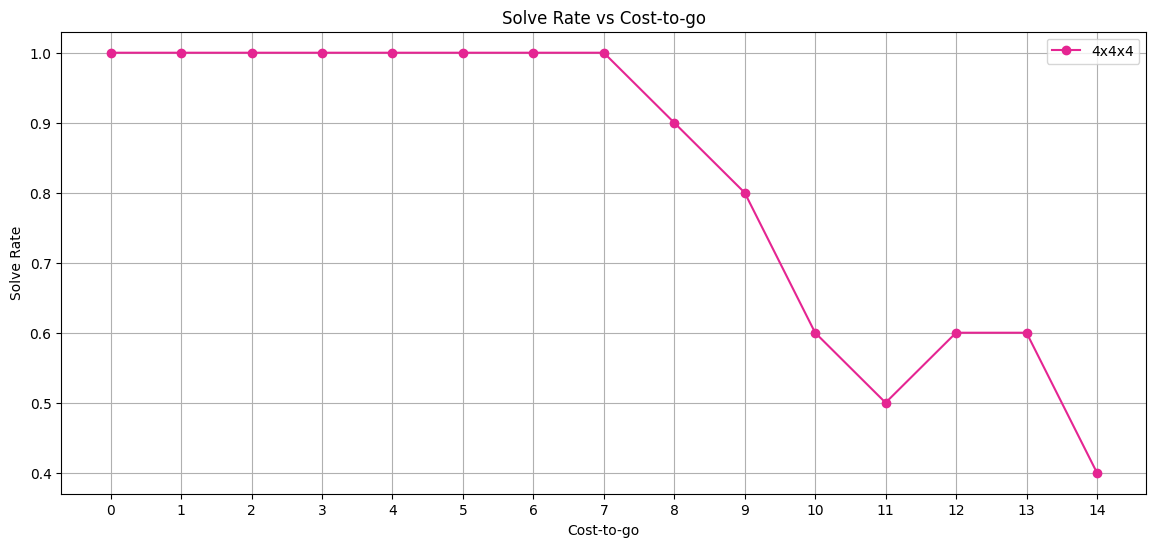

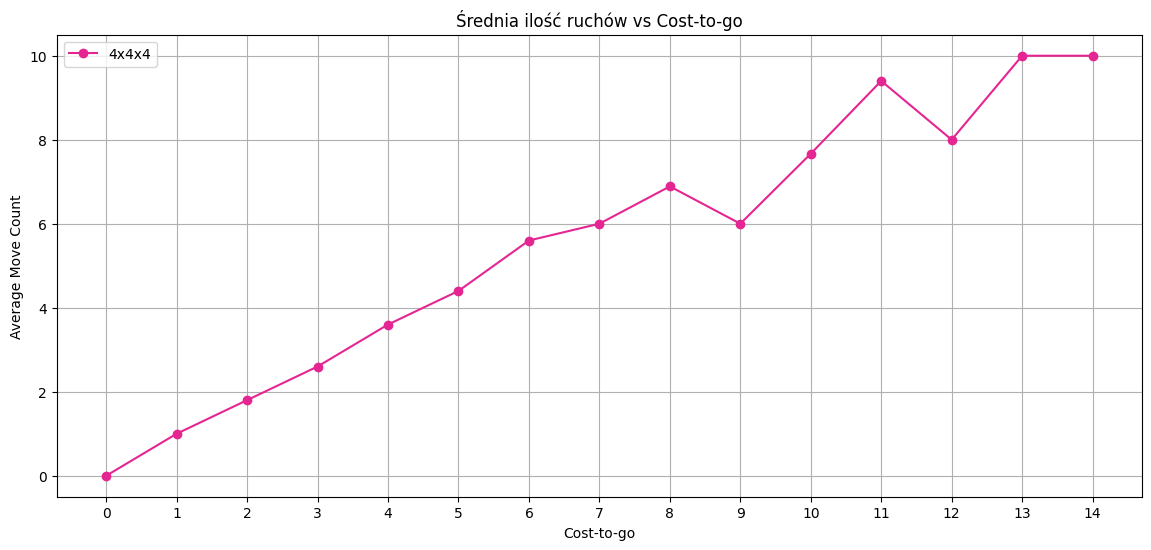

<Figure size 640x480 with 0 Axes>

In [25]:
cube_sizes = [4]
cost_to_gos = range(0, 15)
env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'animation_enabled': False
}
solve_rates_4x4x4, move_counts_4x4x4 = test_astar(
  model_paths, cube_sizes, cost_to_gos, env_setup)
plot_results(solve_rates_4x4x4, move_counts_4x4x4, cost_to_gos)

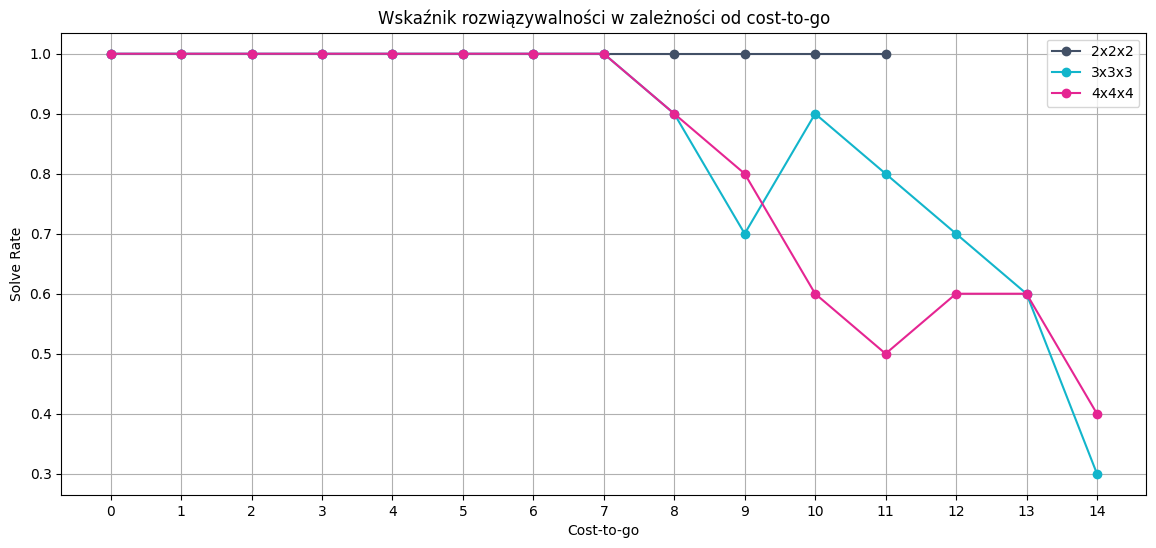

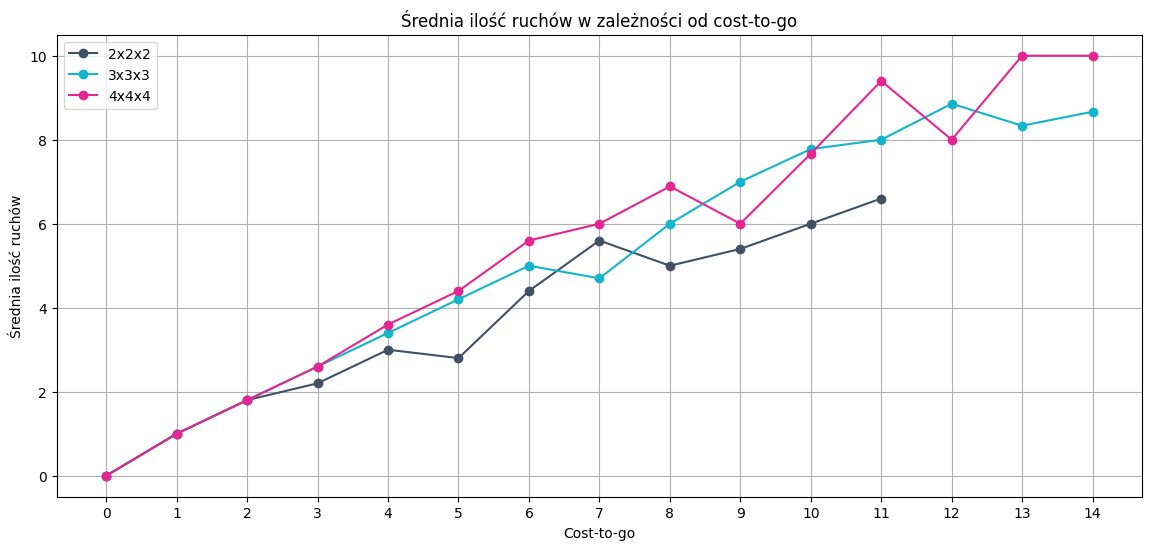

<Figure size 640x480 with 0 Axes>

In [30]:
combined_solve_rates = {
    '2': solve_rates_2x2x2[2],
    '3': solve_rates_3x3x3[3],
    '4': solve_rates_4x4x4[4]
}

combined_move_counts = {
    '2': move_counts_2x2x2[2],
    '3': move_counts_3x3x3[3],
    '4': move_counts_4x4x4[4]
}

combined_costs_to_go = list(range(0, 15))

plot_results(combined_solve_rates, combined_move_counts, combined_costs_to_go)

In [27]:
combined_solve_rates

{'2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 '3': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9,
  0.7,
  0.9,
  0.8,
  0.7,
  0.6,
  0.3],
 '4': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9,
  0.8,
  0.6,
  0.5,
  0.6,
  0.6,
  0.4]}

In [28]:
combined_move_counts

{'2': [0.0, 1.0, 1.8, 2.2, 3.0, 2.8, 4.4, 5.6, 5.0, 5.4, 6.0, 6.6],
 '3': [0.0,
  1.0,
  1.8,
  2.6,
  3.4,
  4.2,
  5.0,
  4.7,
  6.0,
  7.0,
  7.777777777777778,
  8.0,
  8.857142857142858,
  8.333333333333334,
  8.666666666666666],
 '4': [0.0,
  1.0,
  1.8,
  2.6,
  3.6,
  4.4,
  5.6,
  6.0,
  6.888888888888889,
  6.0,
  7.666666666666667,
  9.4,
  8.0,
  10.0,
  10.0]}